# Random Forest Classifier

In [1]:
# Import packages

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn

from hn.load_data import load_data


from sklearn import model_selection, metrics, feature_selection, preprocessing, neighbors, decomposition, svm
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA, KernelPCA
from sklearn.kernel_approximation import RBFSampler

In [2]:
def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# Nieuwe RandomForest

In [3]:
# Preprocessing function

def data_preprocessing(X_train, y_train, X_validation, y_validation):
    '''Data preprocessing'''

    # 1. Scaling 
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validation_scaled = scaler.transform(X_validation)

    # 2. Feature selection/extraction
    # Using the Cumulative Summation of the Explained Variance, we concluded that to  
    # retain 95% of the variance we need to use 30 components.
    pca = decomposition.PCA(n_components=30)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_validation_scaled)

    return X_train_pca, X_validation_pca

In [9]:
# Preprocessing function of Univariate Analysis 

def data_preprocessing_Uni(X_train, y_train, X_test, y_test):
    '''Data preprocessing Univariate'''

    # 1. Scaling 
    scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    df_X_train_scaled = pd.DataFrame(X_train_scaled)
    X_validation_scaled = scaler.transform(X_validation)
    df_X_validation_scaled = pd.DataFrame(X_validation_scaled)

    bestfeatures = SelectKBest(score_func=mutual_info_classif, k=20)
    fit = bestfeatures.fit(df_X_train_scaled,y_train)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(df_X_train_scaled.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    #print(featureScores.nlargest(10,'Score'))  #print 10 best features
    best_features = featureScores.nlargest(20,'Score')['Specs']
    #print(best_features)
    df_X_train_features = df_X_train_scaled[best_features]
    df_X_validation_features = df_X_validation_scaled[best_features]

    return df_X_train_features, df_X_validation_features

The number of samples: 113
The number of features: 159
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.8s finished
100
gini
True
0.6599264705882353
0.6521739130434783
################################################################################
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    9.8s finished
400
entropy
False
0.7913602941176471
0.7391304347826086
################################################################################
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers

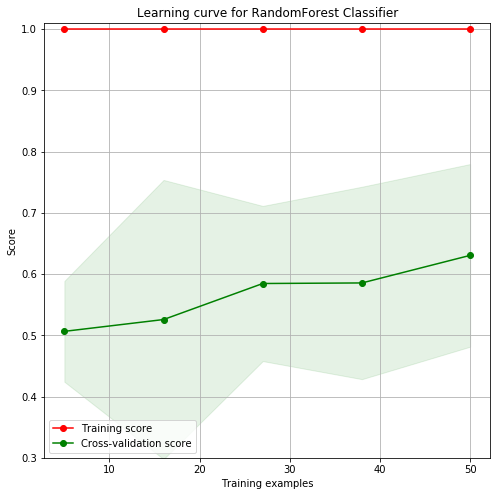

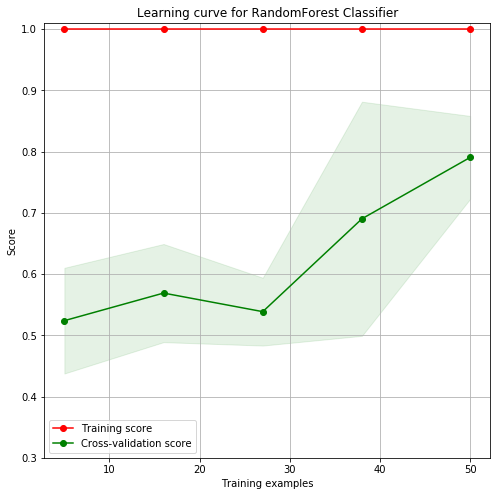

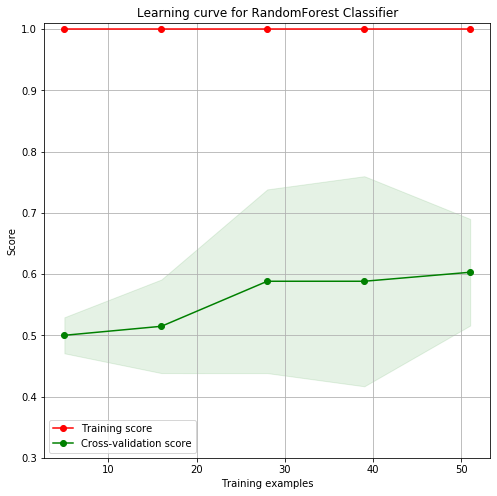

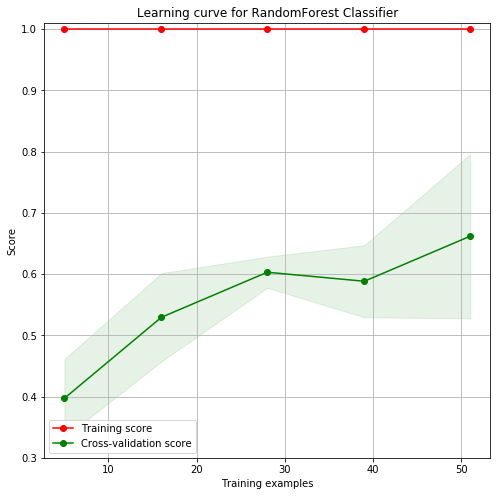

In [10]:
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
all_train = []
all_test = []
# for _ in range (0, 2):
#     train_scores = []
#     test_scores = []
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    train_scores = []
    test_scores = []
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    ## Preprocessing 
    df_X_train_features, df_X_validation_features = data_preprocessing(X_train, y_train, X_validation, y_validation)

    ## RandomForest Classification
    # Stratified K-fold Cross validation
    k = 4
    skf = StratifiedKFold(k, random_state=0) # cv kan ook op None --> geeft default --> 5-fold cross validation

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
    grid_search.fit(df_X_train_features, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(n_estimators)
    print(criterion)
    print(bootstrap)
    best_result = grid_search.best_score_  
    print(best_result)

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(df_X_train_features, y_train)

    # Calculate accuracy
    classifier_predictions_test = classifier.predict(df_X_validation_features)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(accuracy)
    print('#'*80)

    # Learning curve
    title = 'Learning curve for RandomForest Classifier'
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plot_learning_curve(classifier, title, df_X_train_features, y_train, ax, ylim=(0.3, 1.01), cv=skf)

        

The number of samples: 113
The number of features: 159
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   13.2s finished
200
entropy
True
0.6424632352941176
0.6521739130434783
################################################################################
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    9.6s finished
100
gini
False
0.6415441176470589
0.6086956521739131
################################################################################
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers

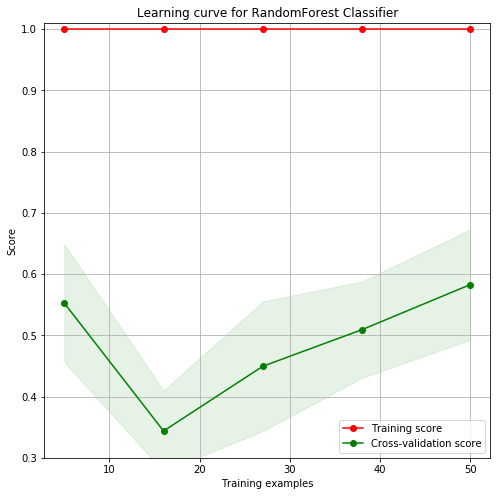

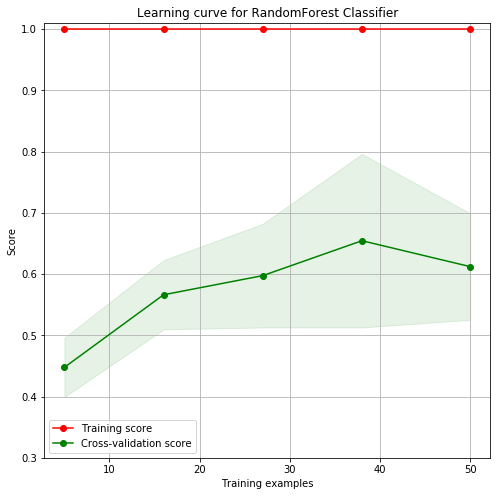

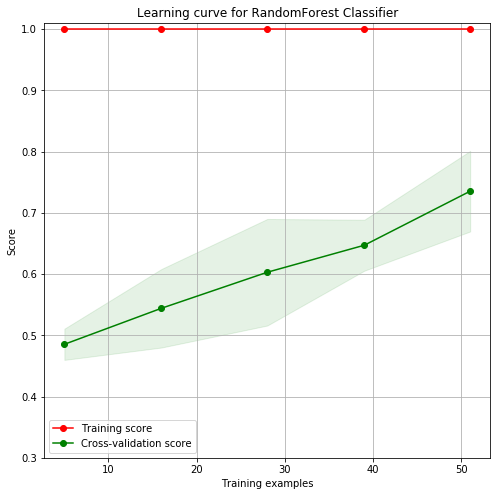

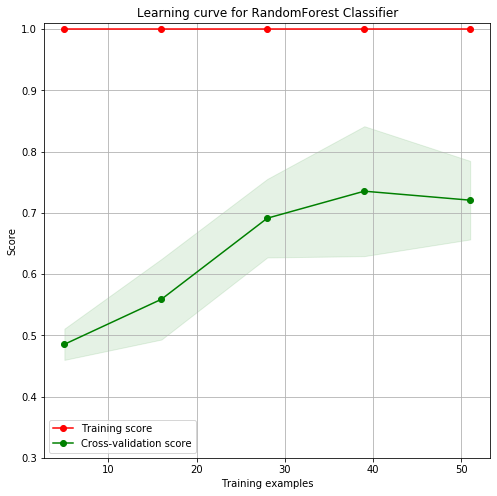

In [4]:
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
all_train = []
all_test = []
# for _ in range (0, 2):
#     train_scores = []
#     test_scores = []
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    train_scores = []
    test_scores = []
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]

    ## Preprocessing 
    X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)

    ## RandomForest Classification
    # Stratified K-fold Cross validation
    k = 4
    skf = StratifiedKFold(k, random_state=0) # cv kan ook op None --> geeft default --> 5-fold cross validation

    # Tuning the hyperparameters
    grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
    grid_search = GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
    grid_search.fit(X_train_pca, y_train)

    best_hyperparameters = grid_search.best_params_

    # Best hyperparameters
    n_estimators = best_hyperparameters.get('n_estimators')
    criterion = best_hyperparameters.get('criterion')
    bootstrap = best_hyperparameters.get('bootstrap')
    print(n_estimators)
    print(criterion)
    print(bootstrap)
    best_result = grid_search.best_score_  
    print(best_result)

    # Apply classifier with tuned hyperparameters
    classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
    classifier.fit(X_train_pca, y_train)


    # Calculate accuracy
    classifier_predictions_test = classifier.predict(X_validation_pca)
    accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
    print(accuracy)
    print('#'*80)

    # Learning curve
    title = 'Learning curve for RandomForest Classifier'
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    plot_learning_curve(classifier, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=skf)

        

In [15]:
# OUD
# Data loading and preprocessing

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)

# Loop over the folds
all_train = []
all_test = []
# for _ in range (0, 2):
#     train_scores = []
#     test_scores = []
    for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
        train_scores = []
        test_scores = []
        X_validation = split_X_train.iloc[validation_index]
        y_validation = split_y_train[validation_index]
        X_train = split_X_train.iloc[training_index]
        y_train = split_y_train[training_index]

        ## Preprocessing 
        X_train_pca, X_validation_pca = data_preprocessing(X_train, y_train, X_validation, y_validation)

        ## RandomForest Classification
        # Stratified K-fold Cross validation
        k = 4
        skf = StratifiedKFold(k, random_state=0) # cv kan ook op None --> geeft default --> 5-fold cross validation

        # Tuning the hyperparameters
        grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
        grid_search = GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
        grid_search.fit(X_train_pca, y_train)

        best_hyperparameters = grid_search.best_params_

        # Best hyperparameters
        n_estimators = best_hyperparameters.get('n_estimators')
        criterion = best_hyperparameters.get('criterion')
        bootstrap = best_hyperparameters.get('bootstrap')
        print(n_estimators)
        print(criterion)
        print(bootstrap)
        best_result = grid_search.best_score_  
        print(best_result)

        # Apply classifier with tuned hyperparameters
        classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
        classifier.fit(X_train_pca, y_train)
        score_train = classifier.score(X_train_pca, y_train)
        score_test = classifier.score(X_validation_pca, y_validation)
        
        train_scores.append(score_train)
        test_scores.append(score_test)

    all_train.append(train_scores)
    all_test.append(test_scores)

# Create numpy array of scores and calculate the mean and std
all_train = np.array(all_train)
all_test = np.array(all_test)

train_scores_mean = all_train.mean(axis=0)
train_scores_std = all_train.std(axis=0)

test_scores_mean = all_test.mean(axis=0)
test_scores_std = all_test.std(axis=0)

# Plot the mean scores and the std as shading
train_sizes = [0,1,2,3]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.grid()
ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
        label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
        label="Test score")

        # # Calculate accuracy
        # classifier_predictions_test = classifier.predict(X_validation_pca)
        # accuracy = metrics.accuracy_score(y_validation, classifier_predictions_test)
        # print(accuracy)
        # print('#'*80)

    # # Learning curves
    # num = 0
    # fig = plt.figure(figsize=(24,8*len(classifier)))
    # for clf in classifier:
    #     title = str(type(clf))
    #     ax = fig.add_subplot(7, 3, num + 1)
    #     plot_learning_curve(clf, title, X_train_pca, y_train, ax, ylim=(0.3, 1.01), cv=skf)
    #     num += 1


The number of samples: 113
The number of features: 159
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.6s finished
100
gini
True
0.6544117647058824
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
10
entropy
False
0.7904411764705882
Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Done  51 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   10.9s finished
200
gini
True
0.6470588235294118
Fitting 4 folds for each of 20 ca

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

# Oude RandomForest

In [3]:
# Data
from hn.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of features: {len(data.columns)-1}')
y_labels = data['label']
del data['label']

y = sklearn.preprocessing.label_binarize(y_labels, ['T12', 'T34']) # 0 now stands for T12 and 1 for T34
y = [i[0] for i in y]
y = np.array(y)

cv_4fold = model_selection.StratifiedKFold(n_splits=4, shuffle=True)
split_X_train, split_X_test, split_y_train, split_y_test = train_test_split(data, y,
                                                    stratify=y, 
                                                    test_size=0.2)
from sklearn.linear_model import LogisticRegression

# Loop over the folds
for training_index, validation_index in cv_4fold.split(split_X_train, split_y_train):
    X_validation = split_X_train.iloc[validation_index]
    y_validation = split_y_train[validation_index]
    X_train = split_X_train.iloc[training_index]
    y_train = split_y_train[training_index]
    #print(f'Validation size in current fold = {len(X_validation)}')

    scaler = preprocessing.StandardScaler()
    # scaler = preprocessing.MinMaxScaler()
    # scaler = preprocessing.RobustScaler()
    scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_validation)
    X_train_scaled = scaler.transform(X_train)
    #apply preprocessing

    n_selected_features = 10
    n_samples = len(X_train.index)
    n_components = min(n_samples, n_selected_features)
    pca = decomposition.PCA(n_components)
    pca.fit(X_train_scaled)
    X_train_pca = pca.transform(X_train_scaled)
    X_validation_pca = pca.transform(X_test_scaled)

The number of samples: 113
The number of features: 159


In the lecture, we have seen that a random forest has a natural form of feature selection and feature importance. Hence, you may use this feature to find out which features have the most predictive value

Opties --> (n_estimators=100, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)

In opdracht 2.1
n_estimators = kan alles zijn
bootstrap = True False allebei gebruikt
class_weight gevarieerd

Lastly, if you have an imbalance in your dataset, or one class is more important than the other, you may want
to alter the class weigh in the random forest.

In [32]:
# Stratified K-fold Cross validation
k=4 # K-fold
skf = StratifiedKFold(k, random_state=0) 
# cv kan ook op None --> geeft default --> 5-fold cross validation

In [33]:
# Tuning the hyperparameters
grid_param = {'n_estimators': [10, 50, 100, 200, 400],'criterion': ['gini', 'entropy'],'bootstrap': [True, False]}
grid_search=GridSearchCV(RandomForestClassifier(),param_grid=grid_param,cv=skf,n_jobs=-1,verbose=2) 
grid_search.fit(X_train_pca, y_train)

pd.DataFrame(grid_search.cv_results_)

Fitting 4 folds for each of 20 candidates, totalling 80 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   12.3s finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045576,0.003659,0.003035,0.000581,True,gini,10,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.470588,0.588235,0.529412,0.647059,0.558824,0.065767,19
1,0.364433,0.019454,0.033037,0.011247,True,gini,50,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.529412,0.647059,0.588235,0.647059,0.602941,0.048774,12
2,0.409993,0.042606,0.073391,0.032532,True,gini,100,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.529412,0.764706,0.529412,0.647059,0.617647,0.097548,9
3,1.066013,0.164501,0.063850,0.017354,True,gini,200,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.529412,0.764706,0.529412,0.647059,0.617647,0.097548,9
4,1.788096,0.103407,0.092067,0.003814,True,gini,400,"{'bootstrap': True, 'criterion': 'gini', 'n_es...",0.529412,0.882353,0.470588,0.647059,0.632353,0.157703,4
5,0.036658,0.006549,0.002496,0.000074,True,entropy,10,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.647059,0.588235,0.529412,0.529412,0.573529,0.048774,18
6,0.183432,0.007199,0.011111,0.002742,True,entropy,50,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.588235,0.588235,0.529412,0.647059,0.588235,0.041595,16
7,0.477816,0.082104,0.043994,0.020770,True,entropy,100,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.529412,0.764706,0.470588,0.647059,0.602941,0.112958,12
8,0.722489,0.013397,0.042944,0.001808,True,entropy,200,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.529412,0.823529,0.529412,0.647059,0.632353,0.120373,4
9,1.649211,0.153111,0.114786,0.048117,True,entropy,400,"{'bootstrap': True, 'criterion': 'entropy', 'n...",0.529412,0.882353,0.529412,0.647059,0.647059,0.144088,3


In [34]:
best_hyperparameters = grid_search.best_params_

n_estimators=best_hyperparameters.get('n_estimators')
criterion=best_hyperparameters.get('criterion')
bootstrap=best_hyperparameters.get('bootstrap')
print(n_estimators)
print(criterion)
print(bootstrap)
best_result = grid_search.best_score_  
print(best_result) 

50
gini
False
0.6470588235294118


In [35]:
classifier = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, bootstrap=bootstrap)
classifier.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [36]:
classifier_predictions_test=classifier.predict(X_validation_pca)

accuracy=metrics.accuracy_score(y_validation, classifier_predictions_test)
print(accuracy)


0.6818181818181818
